<div style="text-align: center;">
  <h1>
    Farah Syahirah Binti Rasidi (P151357)
  </h1>
  <h2>
    Assignment 1<br>
    STQD6324 - Data Management<br>
    Semester 2 2024/2025
  </h2>
</div>

<a name="intro"></a>
# Introduction

> The WHO Mortality database is from [WHO](https://www.who.int/data/data-collection-tools/who-mortality-database). The downloaded version can be taken from my [gdrive](https://drive.google.com/drive/folders/14PrwzXTat6caKXj_XuvD0s4IlEoIaibG?usp=drive_link) for reproducibility.

The purpose of this project is to analyze mortality database containing the annual mortality from year 1988 to 2023 across 462776 countries. This database also provide information regarding demographic data such as sex and age and cause-of-death. Multiple tools will be used upon completing this assessment such as Apache Hive, Apache Pig, as well as Python (via Google Colab). 

---

Contents:
*   [Introduction](#intro)
*   [Problem Statement](#problem-statement)
*   [Data Cleaning](#data-cleaning)
*   [Visualization](#visualization)
*   [Insights and Explanations](#InE)
*   [Conclusion](#conclusion)

## File Description

The database contains multiple files of Morticd10 which splits into 6 parts (all mutually exclusive) and one file of country_codes:

> 1.  `Morticd10_part1` (1,022,017 records) - ICD-10 data up to 2002
2.  `Morticd10_part2` ( 958,647 records) – ICD-10 data for 2003-2007
3.  `Morticd10_part3` (1,045,687 records) – ICD-10 data for 2008-2012
3.  `Morticd10_part4` ( 885,319 records) – ICD-10 data for 2013-2016
4.  `Morticd10_part5` ( 863,021 records) – ICD-10 data for 2017-2020
5.  `Morticd10_part6` ( 369,240 records) – ICD-10 data for 2021 onwards
6.  `Country_codes`- Country codes and names. Total records 227)

In [1]:
import pandas as pd
#create file_layout
file_layout = {
    'Column name': ['Country','Admin1','Subdiv','Year','List','Cause','Sex','Frmat','IM_Frmat','Deaths1','Deaths2','Deaths3','Deaths4',
                   'Deaths5','Deaths6','Deaths7','Deaths8','Deaths9','Deaths10','Deaths11','Deaths12','Deaths13','Deaths14','Deaths15',
                   'Deaths16','Deaths17','Deaths18','Deaths19','Deaths20','Deaths21','Deaths22','Deaths23','Deaths24','Deaths25','Deaths26',
                    'IM_deaths1','IM_deaths2','IM_deaths3','IM_deaths4'],
    'Content': ['Country code – see file Country_codes.csv', 'Specified region/Category pertinent to each country', 'Category of data', 
                'Year to which data refer', 'List of ICD revision used', 'Cause of death – For details consult Part 2 below or ICD publications',
                '1 male, 2 female and 9 sex unspecified', 'Age-group format for breakdown of deaths at 0-95+ yrs', 'Age format for breakdown of infant deaths (0 year)',
                'Deaths at all ages', 'Deaths at age 0 year', 'Deaths at age 1 year', 'Deaths at age 2 years', 'Deaths at age 3 years', 
                'Deaths at age 4 years', 'Deaths at age 5-9 years', 'Deaths at age 10-14 years', 'Deaths at age 15-19 years',
                'Deaths at age 20-24 years', 'Deaths at age 25-29 years', 'Deaths at age 30-34 years', 'Deaths at age 35-39 years',
                'Deaths at age 40-44 years', 'Deaths at age 45-49 years', 'Deaths at age 50-54 years', 'Deaths at age 55-59 years', 'Deaths at age 60-64 years',
                'Deaths at age 65-69 years', 'Deaths at age 70-74 years', 'Deaths at age 75-79 years', 'Deaths at age 80-84 years', 'Deaths at age 85-89 years',
                'Deaths at age 90-94 years', 'Deaths at age 95 years and above', 'Deaths at age unspecified', 'Infant deaths at age 0 day',
                'Infant deaths at age 1-6 days', 'Infant deaths at age 7-27 days', 'Infant deaths at age 28-364 days']
}

# Create DataFrame based on file_layout
fl = pd.DataFrame(file_layout)

### File layout

For files of Morticd10, the layout for each line of data is as follows:

In [2]:
print(fl.to_markdown(index=False))     #display table

| Column name   | Content                                                               |
|:--------------|:----------------------------------------------------------------------|
| Country       | Country code – see file Country_codes.csv                             |
| Admin1        | Specified region/Category pertinent to each country                   |
| Subdiv        | Category of data                                                      |
| Year          | Year to which data refer                                              |
| List          | List of ICD revision used                                             |
| Cause         | Cause of death – For details consult Part 2 below or ICD publications |
| Sex           | 1 male, 2 female and 9 sex unspecified                                |
| Frmat         | Age-group format for breakdown of deaths at 0-95+ yrs                 |
| IM_Frmat      | Age format for breakdown of infant deaths (0 year)                    |
| Deaths1 

<a name="problem-statement"></a>
# Problem Statement

As a future data scientist, I am interested in the relationship between the deaths and demographic variables which are country, sex and age group. This analysis aims to understand the trend or pattern of the dataset and understand the working relationship between corresponding variables to the number of deaths. The working analysis can be broken down into:


> 1.   [Descriptive Analytics](#descr-analytics)
>> *   What are the proportions of total deaths in difference age group and sex across different countries?
>> *   What is the trend of deaths for each age group?
> 3.   [Comparison Analytics](#comp-analytics)
>> *   Is there a significant difference in mortality rates from cardiovascular diseases between early-old (65–74), middle-old (75–84) and oldest old populations?
>> *   How differ the three most high cause of deaths of oldest-old (85+) age group between United States of America and Russian Federation?

# Data Cleaning

In [18]:
# Install all the required packages
import pandas as pd               #for handling data
import numpy as np                #for numerical computation
import matplotlib.pyplot as plt   #for plotting or visualization
from pmdarima import auto_arima   #for forecasting time series data
import seaborn as sns             #for plotting or graph visualization

In [7]:
#connect jupyter to hdp
from impala.dbapi import connect

cursor = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='dm_asg1',
    auth_mechanism='PLAIN'
).cursor()
#Execute a query to show tables available
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('country_codes',), ('morticd10_part1',), ('morticd10_part2',), ('morticd10_part3',), ('morticd10_part4',), ('morticd10_part5',), ('morticd10_part6',)]


In [8]:
dataframe= []  #make empty list for looping the files inside the tuple

# looping files and add files in the empty tuple of dataframe
for i in range(1,7):
    csvfile= f'Morticd10_part{i}.csv' #Morticd10_part is the name of the file
    mortality= pd.read_csv(csvfile)   #read each file
    dataframe.append(mortality)       #append/add file

combined_mortality= pd.concat(dataframe, ignore_index=True) #combine all dataframes to become a new single dataframe

print(combined_mortality.head(5))

C:\Users\user\AppData\Local\Temp\ipykernel_4748\1895969132.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mortality= pd.read_csv(csvfile)   #read each file
C:\Users\user\AppData\Local\Temp\ipykernel_4748\1895969132.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mortality= pd.read_csv(csvfile)   #read each file
C:\Users\user\AppData\Local\Temp\ipykernel_4748\1895969132.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  mortality= pd.read_csv(csvfile)   #read each file
C:\Users\user\AppData\Local\Temp\ipykernel_4748\1895969132.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  mortality= pd.read_csv(csvfile)   #read each file
C:\Users\user\AppData\Local\Temp\ipykernel_4748\1895969132.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on

   Country  Admin1 SubDiv  Year List Cause  Sex  Frmat  IM_Frmat  Deaths1  \
0     1400     NaN    NaN  2001  101  1000    1      7         8      332   
1     1400     NaN    NaN  2001  101  1000    2      7         8      222   
2     1400     NaN    NaN  2001  101  1001    1      7         8       24   
3     1400     NaN    NaN  2001  101  1001    2      7         8       14   
4     1400     NaN    NaN  2001  101  1002    1      7         8        0   

   ...  Deaths21  Deaths22  Deaths23  Deaths24  Deaths25  Deaths26  \
0  ...      95.0       NaN       NaN       NaN       NaN       0.0   
1  ...     112.0       NaN       NaN       NaN       NaN       0.0   
2  ...       5.0       NaN       NaN       NaN       NaN       0.0   
3  ...       6.0       NaN       NaN       NaN       NaN       0.0   
4  ...       0.0       NaN       NaN       NaN       NaN       0.0   

   IM_Deaths1  IM_Deaths2  IM_Deaths3  IM_Deaths4  
0         8.0         NaN         NaN         NaN  
1        11.

In [6]:
combined_mortality.info() #check column type, missing entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5143931 entries, 0 to 5143930
Data columns (total 39 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Country     int64  
 1   Admin1      float64
 2   SubDiv      object 
 3   Year        int64  
 4   List        object 
 5   Cause       object 
 6   Sex         int64  
 7   Frmat       int64  
 8   IM_Frmat    int64  
 9   Deaths1     int64  
 10  Deaths2     float64
 11  Deaths3     float64
 12  Deaths4     float64
 13  Deaths5     float64
 14  Deaths6     float64
 15  Deaths7     float64
 16  Deaths8     float64
 17  Deaths9     float64
 18  Deaths10    float64
 19  Deaths11    float64
 20  Deaths12    float64
 21  Deaths13    float64
 22  Deaths14    float64
 23  Deaths15    float64
 24  Deaths16    float64
 25  Deaths17    float64
 26  Deaths18    float64
 27  Deaths19    float64
 28  Deaths20    float64
 29  Deaths21    float64
 30  Deaths22    float64
 31  Deaths23    float64
 32  Deaths24    float64
 33  Deaths2

In [7]:
combined_mortality.duplicated().any() #check for repeated rows

False

In [8]:
combined_mortality.isna().sum() #check for the total of NA value in each column

Country             0
Admin1        5059758
SubDiv        5136458
Year                0
List                0
Cause               0
Sex                 0
Frmat               0
IM_Frmat            0
Deaths1             0
Deaths2         77117
Deaths3         77117
Deaths4        348480
Deaths5        348480
Deaths6        348480
Deaths7         77117
Deaths8         81099
Deaths9         77117
Deaths10        81099
Deaths11        77117
Deaths12        81099
Deaths13        77117
Deaths14        81099
Deaths15        77117
Deaths16        81099
Deaths17        77117
Deaths18        81099
Deaths19        77117
Deaths20        81423
Deaths21        77441
Deaths22       102846
Deaths23       102846
Deaths24       765213
Deaths25       765213
Deaths26        83483
IM_Deaths1      77117
IM_Deaths2    1116341
IM_Deaths3    1032539
IM_Deaths4    1032539
dtype: int64

### Handling Missing Entries/NA

As per WHO guidlines, in the data, NA denotes unavalaible or not recorded data due to incomplete registration coverage, non-reporting or exclusion from the vital registration systems's scope. 

For this analysis, NA means no deaths registered. The columns is then grouped with other columns to match the age group according to gerontological standards.

### Age Group Category
the age group is very large. Hence, I decided to group the age into five groups:

>1) **Young Age** group that consists of:
    - Infant -(0-1) age
    - Early_childhood -(2-5) age
    - Middle_childhood -(6-11) age
    - Adolescence -(12-17) age
    - Young_Adult -(18-24) age
    - Adult -(25-44) age


>2) **Middle Age** group (45-64) age

>3) **Early_old Age** group (65-74) age

>4) **Middle_old Age** group (75-84) age

>5) **Oldest_old Age** group (85+) age

Note: 
>Age groups follow gerontological standards:
>>- Early-old (65-74),
>>- Middle-old (75-84) and
>>- Oldest-old (85+).
>- Sources: NIA, WHO and Neugarten (1974).
- Link: [NIA Aging Categories](https://www.nia.nih.gov/). [WHO Aging Report](https://www.who.int/news-room/fact-sheets/detail/ageing-and-health)
- Gerontology Journals. DOI: [10.2307/2094307](https://doi.org/10.2307/2094307)

In [11]:
m= combined_mortality.copy() #create new name gd (group death) without changing the original dataframe

#Create new column 'children' that summed up each rows
m['Young']= m[['IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4','Deaths3', 'Deaths4', 'Deaths5', 'Deaths6', 'Deaths7','Deaths8', 'Deaths9', 'Deaths10', 'Deaths11', 'Deaths12', 'Deaths13', 'Deaths14']].sum(axis= 1) 

#Create new column 'Middle_age' that summed up each rows
m['Middle_age']= m[['Deaths15', 'Deaths16', 'Deaths17', 'Deaths18']].sum(axis= 1)

# create Early old column
m['Early_old']= m[['Deaths19', 'Deaths20']].sum(axis=1)

# create middle_old column
m['Middle_old']= m[['Deaths21', 'Deaths22']].sum(axis=1)

#Create new column 'Oldest_old' that summed up each rows
m['Oldest_old']= m[['Deaths23', 'Deaths24', 'Deaths25']].sum(axis= 1)

### Columns removal
>1) **'Admin1', 'SubDiv'**
>> There's insufficient of information in columns 'Admin1' and 'Subdiv' which represent specified region and category of data respectively. When both fields 'Admin1' and 'Subdiv' are blank, data reported refer to the country. Hence, both columns were removed and 'Country' column is enough to represent the data.
>2) **'Deaths1 and Deaths26'**
>> Deaths1 is representing data at all ages while Deaths26 has unspecified age. Both are removed to have clearer data analysis.
>3) **'Deaths2', 'Deaths3', 'Deaths4', 'Deaths5', 'Deaths6', 'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11', 'Deaths12', 'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17', 'Deaths18', 'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23', 'Deaths24', 'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'**
>> Columns were removed after grouping repective columns into their respective age group.

In [12]:
#remove column
m_drop= m.drop(columns= ['Admin1', 'SubDiv', 'Frmat', 'IM_Frmat', 
                          'Deaths1', 'Deaths2', 'Deaths3', 'Deaths4', 'Deaths5',
                          'Deaths6', 'Deaths7', 'Deaths8', 'Deaths9', 'Deaths10', 'Deaths11',
                          'Deaths12', 'Deaths13', 'Deaths14', 'Deaths15', 'Deaths16', 'Deaths17',
                          'Deaths18', 'Deaths19', 'Deaths20', 'Deaths21', 'Deaths22', 'Deaths23',
                          'Deaths24', 'Deaths25', 'Deaths26', 'IM_Deaths1', 'IM_Deaths2',
                          'IM_Deaths3', 'IM_Deaths4'])

m_drop['Sex']= m_drop['Sex'].replace({1: 'Male', 2: 'Female'}) #label Sex to Male and Female
m_drop= m_drop[m_drop['Sex']!= 9] #remove unspecified sex=9 to have clear analysis for male and female
m_drop['Sex'].unique() #check unique value of SEX

array(['Male', 'Female'], dtype=object)

In [11]:
m_drop.head()

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
4,1400,2001,101,1002,Male,0.0,0.0,0.0,0.0,0.0


In [12]:
m_drop['Country'].unique().sum()

462776

In [13]:
m_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5119607 entries, 0 to 5143930
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Country     int64  
 1   Year        int64  
 2   List        object 
 3   Cause       object 
 4   Sex         object 
 5   Young       float64
 6   Middle_age  float64
 7   Early_old   float64
 8   Middle_old  float64
 9   Oldest_old  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 429.7+ MB


### Handle duplicates

After grouping the age group there's sligtly a changes in the shape and information of the new dataframe ('m_drop' dataframe). The data is checked for its duplicity to ensure whether the duplicates is actually redundant rows or the repeated is only on object columns. 

In [14]:
print(m_drop.duplicated().sum())

23371


In [13]:
#Extract or subset the rows that repeated and see wether it can be removed or keep only one row
subsetduplicates= m_drop[m_drop.duplicated(subset= ['Country', 'Cause', 'Sex'], keep=False)]
subsetduplicates.head(20) 

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
4,1400,2001,101,1002,Male,0.0,0.0,0.0,0.0,0.0
5,1400,2001,101,1002,Female,0.0,0.0,0.0,0.0,0.0
6,1400,2001,101,1003,Male,0.0,0.0,0.0,0.0,0.0
7,1400,2001,101,1003,Female,0.0,0.0,0.0,0.0,0.0
8,1400,2001,101,1004,Male,0.0,0.0,0.0,0.0,0.0
9,1400,2001,101,1004,Female,0.0,0.0,0.0,0.0,0.0


**Decision in duplicate rows**
>In this data, the repeated rows are rows with zero values of numerical columns. Hence, I will remove the rows only that all have zero numerical columns in order to obtain clean data and provide clarity in analysis.

In [14]:
#select only numerical column of age group
numerical_cols= m_drop.select_dtypes(include='float64').columns 

#mark the rows that have 0 values 
zero_numerical= (m_drop[numerical_cols]==0).all(axis=1)
zero_rowsvalue= m_drop[zero_numerical]

zero_rowsvalue

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
4,1400,2001,101,1002,Male,0.0,0.0,0.0,0.0,0.0
5,1400,2001,101,1002,Female,0.0,0.0,0.0,0.0,0.0
6,1400,2001,101,1003,Male,0.0,0.0,0.0,0.0,0.0
7,1400,2001,101,1003,Female,0.0,0.0,0.0,0.0,0.0
8,1400,2001,101,1004,Male,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5042983,1360,2022,104,R02,Female,0.0,0.0,0.0,0.0,0.0
5042984,1360,2022,104,I210,Female,0.0,0.0,0.0,0.0,0.0
5042985,1360,2022,104,M349,Female,0.0,0.0,0.0,0.0,0.0
5109801,4180,2021,104,X38,Female,0.0,0.0,0.0,0.0,0.0


In [74]:
# drop all rows with zero values to have a clean data to analyse
grouped_mortality= m_drop[~zero_numerical]

print('Shape of m_drop dataframe with duplicate rows:')
print(m_drop.shape)
print('Shape of grouped_mortality dataframe  after removing zero numerical values:')
print(grouped_mortality.shape)

Shape of m_drop dataframe with duplicate rows:
(5119607, 10)
Shape of grouped_mortality dataframe  after removing zero numerical values:
(5033838, 10)


In [18]:
#check whether the total duplicate rows tally or not 
5119607-5033838

85769

In [19]:
grouped_mortality.isna().sum() #check for any missing value/entries in the new dataframe

Country       0
Year          0
List          0
Cause         0
Sex           0
Young         0
Middle_age    0
Early_old     0
Middle_old    0
Oldest_old    0
dtype: int64

> #### A cleaned dataframe named grouped_mortality is ready to for analysis
> Action for NA value: No imputation of value as the missing entries is the non registered or non recorded number of deaths. This was confirmed by the WHO
> The larger age group was grouped to form a small 5 age of group follows the gerontological standards:
>>- Early-old (65-74),
>>- Middle-old (75-84) and
>>- Oldest-old (85+).
>- Sources: NIA, WHO and Neugarten (1974).
- Link: [NIA Aging Categories](https://www.nia.nih.gov/). [WHO Aging Report](https://www.who.int/news-room/fact-sheets/detail/ageing-and-health)
- Gerontology Journals. DOI: [10.2307/2094307](https://doi.org/10.2307/2094307)

# Visualization &
# Insights and Explanation

In [75]:
# find mean, max, median for numerical variables
grouped_mortality.describe().round() 

,Country,Year,Young,Middle_age,Early_old,Middle_old,Oldest_old
count,5033838.0,5033838.0,5033838.0,5033838.0,5033838.0,5033838.0,5033838.0
mean,3293.0,2010.0,22.0,38.0,35.0,49.0,44.0
std,988.0,7.0,935.0,1563.0,1394.0,1895.0,1950.0
min,1030.0,1988.0,0.0,0.0,0.0,0.0,0.0
25%,2310.0,2004.0,0.0,0.0,0.0,0.0,0.0
50%,3365.0,2010.0,1.0,1.0,0.0,0.0,0.0
75%,4188.0,2016.0,2.0,2.0,2.0,2.0,1.0
max,5198.0,2023.0,252725.0,470852.0,418941.0,432389.0,617885.0


In [21]:
grouped_mortality.describe(include='object')

,List,Cause,Sex
count,5033838,5033838,5033838
unique,5,11485,2
top,104,AAA,Male
freq,4609185,4916,2643829


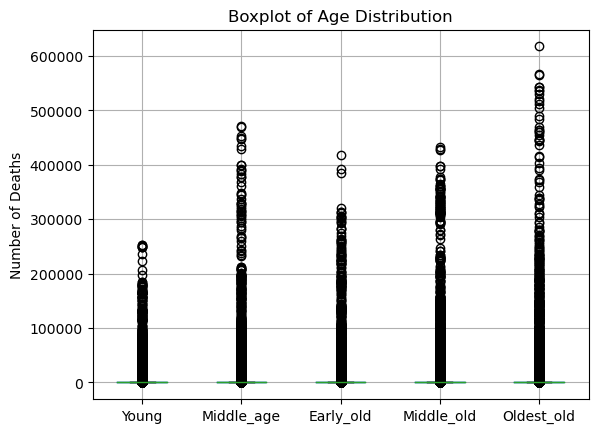

In [21]:
grouped_mortality[['Young', 'Middle_age', 'Early_old', 'Middle_old', 'Oldest_old']].boxplot()
plt.title('Boxplot of Age Distribution')
plt.ylabel('Number of Deaths')
plt.show()

> The highest mortality ranked:
>>- 1) Oldest-old (85+) age
>>- 2) Middle age (45-64) age
>>- 3) Middle-old (75-84) age
>>- 4) Early-old (65-74) age
>>- 5) Young (0-44) age

#### 1) What are the proportions of total deaths in difference age group and sex across different countries?

In [76]:
grouped_mortality.head()

,Country,Year,List,Cause,Sex,Young,Middle_age,Early_old,Middle_old,Oldest_old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
10,1400,2001,101,1005,Male,0.0,0.0,1.0,0.0,0.0


In [86]:
# to merge data from hive, all columns name need to convert to lower case. 
# Hive save name columns by default to lower case eventhough we edited saved it in capital letter
grouped_mortality.columns= grouped_mortality.columns.str.lower()
conn= connect(
    host= '127.0.0.1',
    port= '10000',
    user= 'maria_dev',
    database= 'dm_asg1',
    auth_mechanism= 'PLAIN'
)
cursor= conn.cursor() #column name in hive saved as in complete as tablename.column. Hence, be careful to name the column as in full format
cursor.execute('''
    SELECT
        country_codes.country AS country,
        country_codes.name AS name
    FROM country_codes
''')

#convert table to dataframe
columns= [desc[0] for desc in cursor.description]
hive_countrycodes= cursor.fetchall()
countrycodes= pd.DataFrame(hive_countrycodes, columns= columns)


#Merge to label country to their respective name. Country code from hive and 
#top_cyoung, toptop_cma, top_eo, top_mo, top_oldest
merged_mortalitycountry= pd.merge(grouped_mortality, countrycodes, on='country', how='outer').drop(columns='country').rename(columns={'name':'country'})

print(merged_mortalitycountry)

           year list cause     sex  young  middle_age  early_old  middle_old  \
0        2001.0  101  1000    Male   77.0        92.0       68.0        95.0   
1        2001.0  101  1000  Female   28.0        34.0       48.0       112.0   
2        2001.0  101  1001    Male   11.0         5.0        3.0         5.0   
3        2001.0  101  1001  Female    3.0         5.0        0.0         6.0   
4        2001.0  101  1005    Male    0.0         0.0        1.0         0.0   
...         ...  ...   ...     ...    ...         ...        ...         ...   
5033922     NaN  NaN   NaN     NaN    NaN         NaN        NaN         NaN   
5033923     NaN  NaN   NaN     NaN    NaN         NaN        NaN         NaN   
5033924     NaN  NaN   NaN     NaN    NaN         NaN        NaN         NaN   
5033925     NaN  NaN   NaN     NaN    NaN         NaN        NaN         NaN   
5033926     NaN  NaN   NaN     NaN    NaN         NaN        NaN         NaN   

         oldest_old     country  
0    

In [87]:
# convert back the grouped mortality.columns to capital letter
grouped_mortality.columns= grouped_mortality.columns.str.title()

In [88]:
# convert also the merge_mortalitycountry.columns to capital letter. THIS IS OPTIONAL but i prefer it this way
merged_mortalitycountry.columns= merged_mortalitycountry.columns.str.title()

In [89]:
# extract data for each group 
young_countrysex= merged_mortalitycountry.groupby(['Country', 'Sex'])['Young'].sum().sort_values(ascending=False)
ma_countrysex= merged_mortalitycountry.groupby(['Country', 'Sex'])['Middle_Age'].sum().sort_values(ascending=False)
eo_countrysex= merged_mortalitycountry.groupby(['Country', 'Sex'])['Early_Old'].sum().sort_values(ascending=False)
mo_countrysex= merged_mortalitycountry.groupby(['Country', 'Sex'])['Middle_Old'].sum().sort_values(ascending=False)
oldest_countrysex= merged_mortalitycountry.groupby(['Country', 'Sex'])['Oldest_Old'].sum().sort_values(ascending=False)

top_cyoung1= young_countrysex.head(10).unstack()
top_cma1= ma_countrysex.head(10).unstack()
top_eo1= eo_countrysex.head(10).unstack()
top_mo1= mo_countrysex.head(10).unstack()
top_oldest1= oldest_countrysex.head(10).unstack()

C:\Users\user\AppData\Local\Temp\ipykernel_4748\1173553982.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad= 5.0)


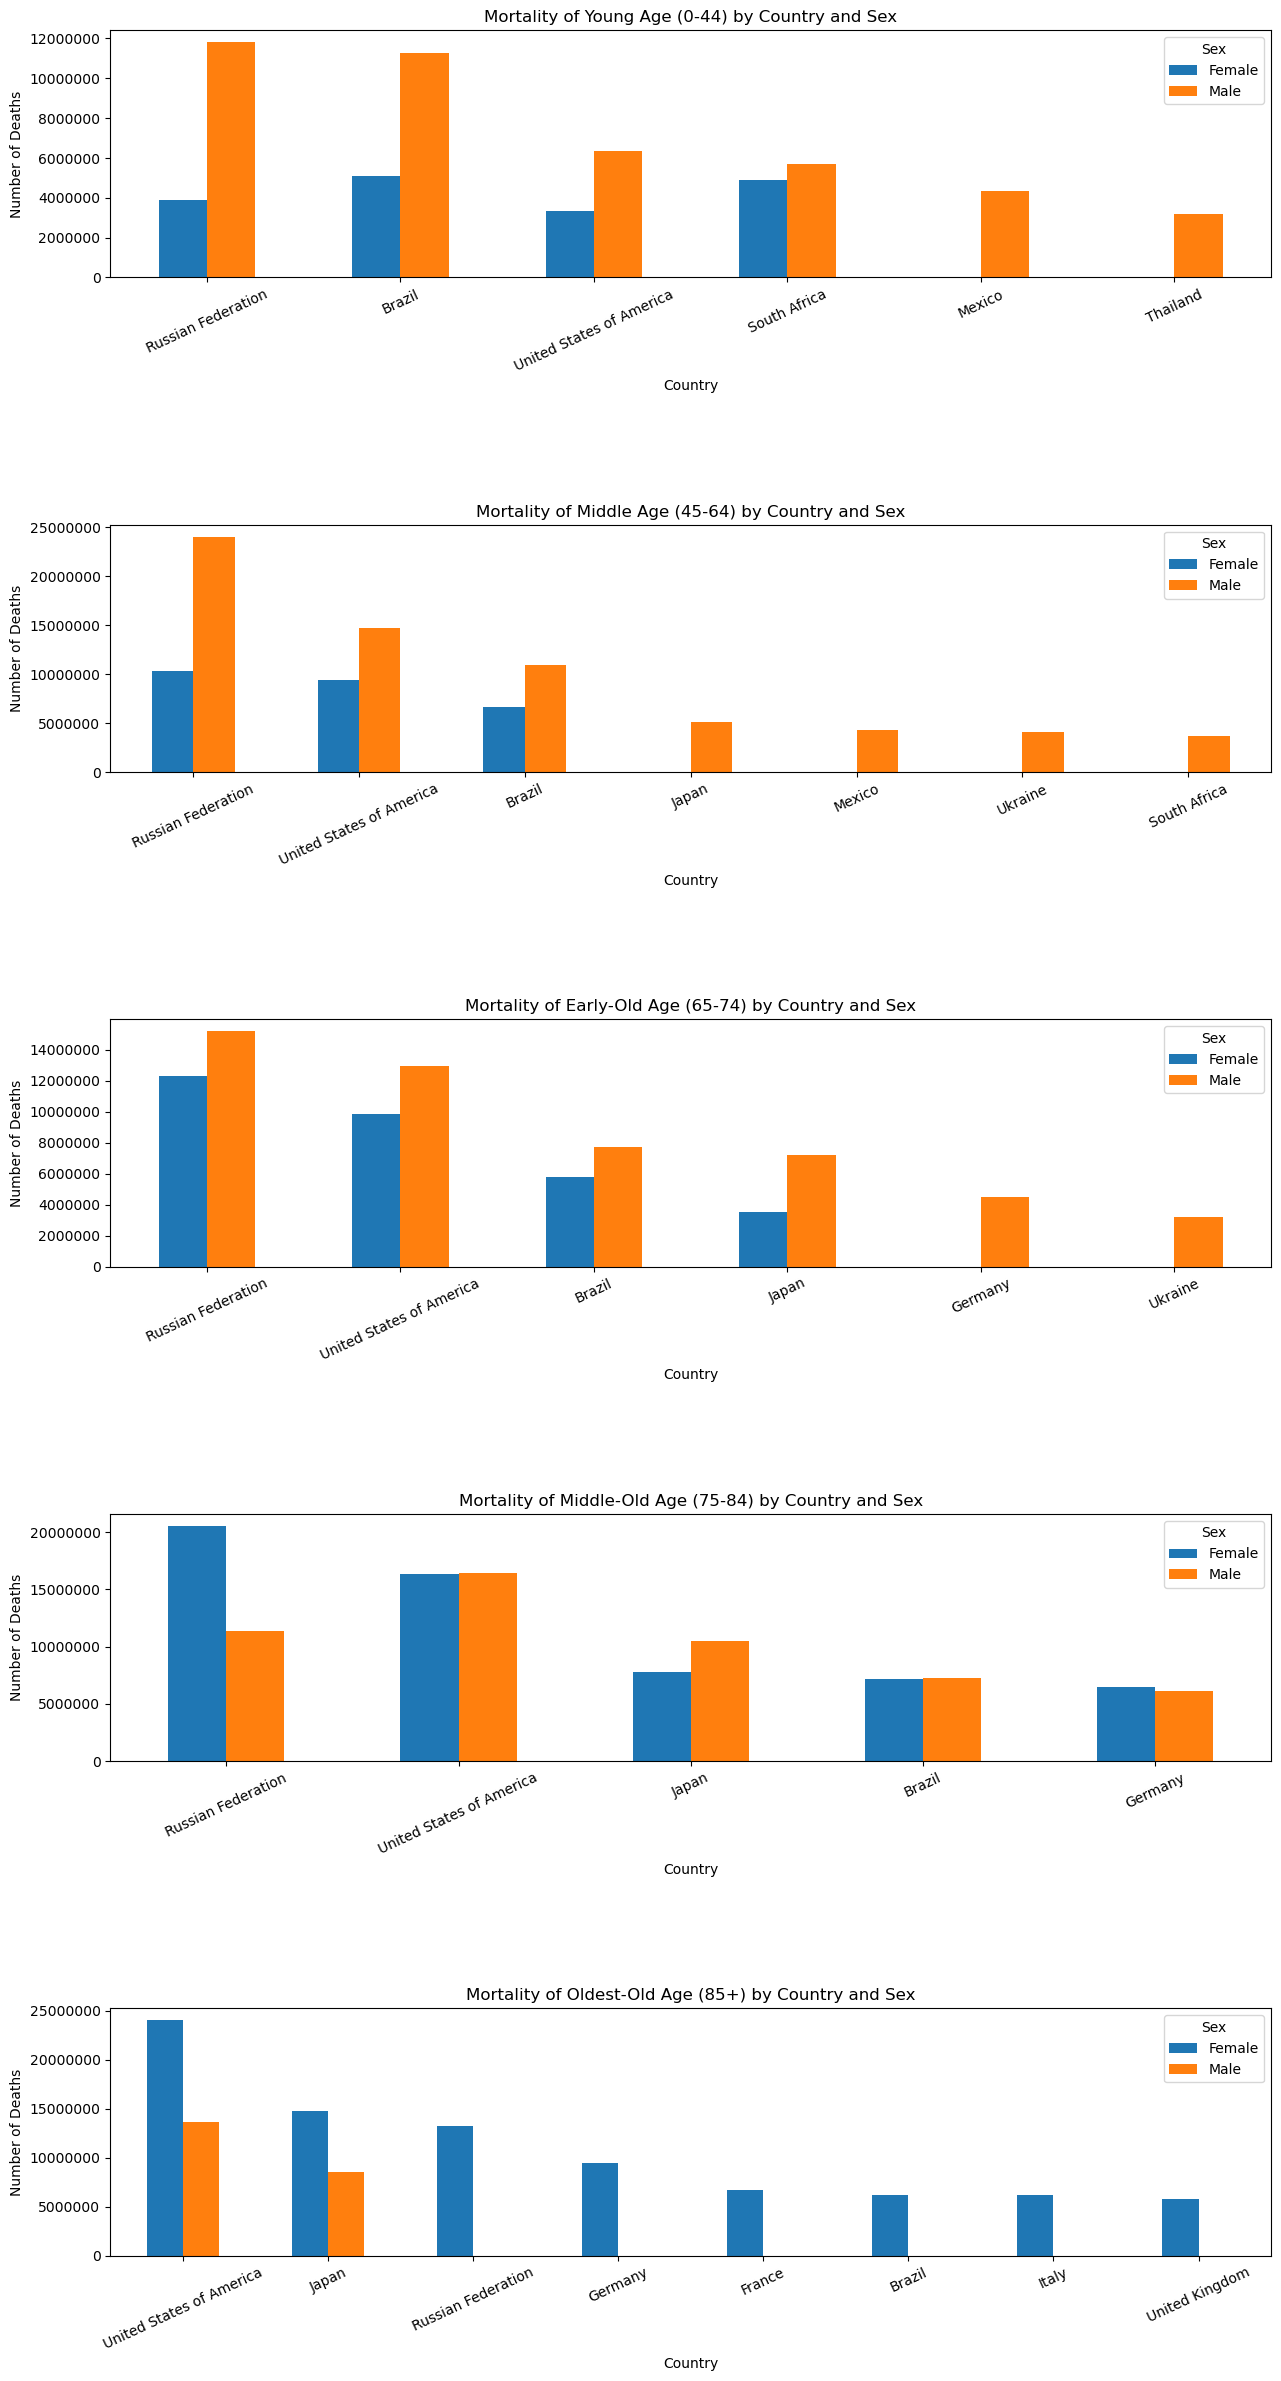

In [90]:
fig, axes= plt.subplots(nrows=5, ncols=1, figsize=(14,25), constrained_layout=True)
axes= axes.flatten()

top_cyoung1.plot(ax=axes[0], kind='bar')
axes[0].set_title('Mortality of Young Age (0-44) by Country and Sex')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of Deaths')
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].tick_params(axis='x', labelsize=10, labelrotation=25)

top_cma1.plot(ax=axes[1], kind='bar')
axes[1].set_title('Mortality of Middle Age (45-64) by Country and Sex')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Number of Deaths')
axes[1].ticklabel_format(style='plain', axis='y')
axes[1].tick_params(axis='x', labelsize=10, labelrotation=25)

top_eo1.plot(ax=axes[2], kind='bar')
axes[2].set_title('Mortality of Early-Old Age (65-74) by Country and Sex')
axes[2].set_xlabel('Country')
axes[2].set_ylabel('Number of Deaths')
axes[2].ticklabel_format(style='plain', axis='y')
axes[2].tick_params(axis='x', labelsize=10, labelrotation=25)

top_mo1.plot(ax=axes[3], kind='bar')
axes[3].set_title('Mortality of Middle-Old Age (75-84) by Country and Sex')
axes[3].set_xlabel('Country')
axes[3].set_ylabel('Number of Deaths')
axes[3].ticklabel_format(style='plain', axis='y')
axes[3].tick_params(axis='x', labelsize=10, labelrotation=25)

top_oldest1.plot(ax=axes[4], kind='bar')
axes[4].set_title('Mortality of Oldest-Old Age (85+) by Country and Sex')
axes[4].set_xlabel('Country')
axes[4].set_ylabel('Number of Deaths')
axes[4].ticklabel_format(style='plain', axis='y')
axes[4].tick_params(axis='x', labelsize=10, labelrotation=25)

plt.tight_layout(pad= 5.0)
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

>- The higher mortality rates's sex is Male
>- Male has highest deaths at group of from 0-84 age and most of them die younger (below 44) as compared to Female the number of deaths is significant.
>- In other words, Females tend to live longer and this gender only has higher deaths number at group age of 75+. Probably the number of deaths started to increase at these age as their health declining with their age. 
>- The most country with highest deaths rate ranked from:
>>- 1) Russian Federation
>>- 2) United States of America
>>- 3) Brazil
>- Russian Federation and United States of America ranked most of age group for higher mortality rates.
>>- probably due to higher number of population size of their country. Besides, they are well known developed countries, thus probably facing high pressure of workload, less effective of healthcare system as the size of them are huge in number.

In [91]:
grouped_mortality.head()

,Country,Year,List,Cause,Sex,Young,Middle_Age,Early_Old,Middle_Old,Oldest_Old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
10,1400,2001,101,1005,Male,0.0,0.0,1.0,0.0,0.0


#### 2) What is the trend of deaths for each age group?

In [92]:
young_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Young'].sum().unstack()
middle_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Middle_Age'].sum().unstack()
eo_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Early_Old'].sum().unstack()
mo_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Middle_Old'].sum().unstack()
oldest_yearsex= grouped_mortality.groupby(['Year','Sex'], as_index=True)['Oldest_Old'].sum().unstack()

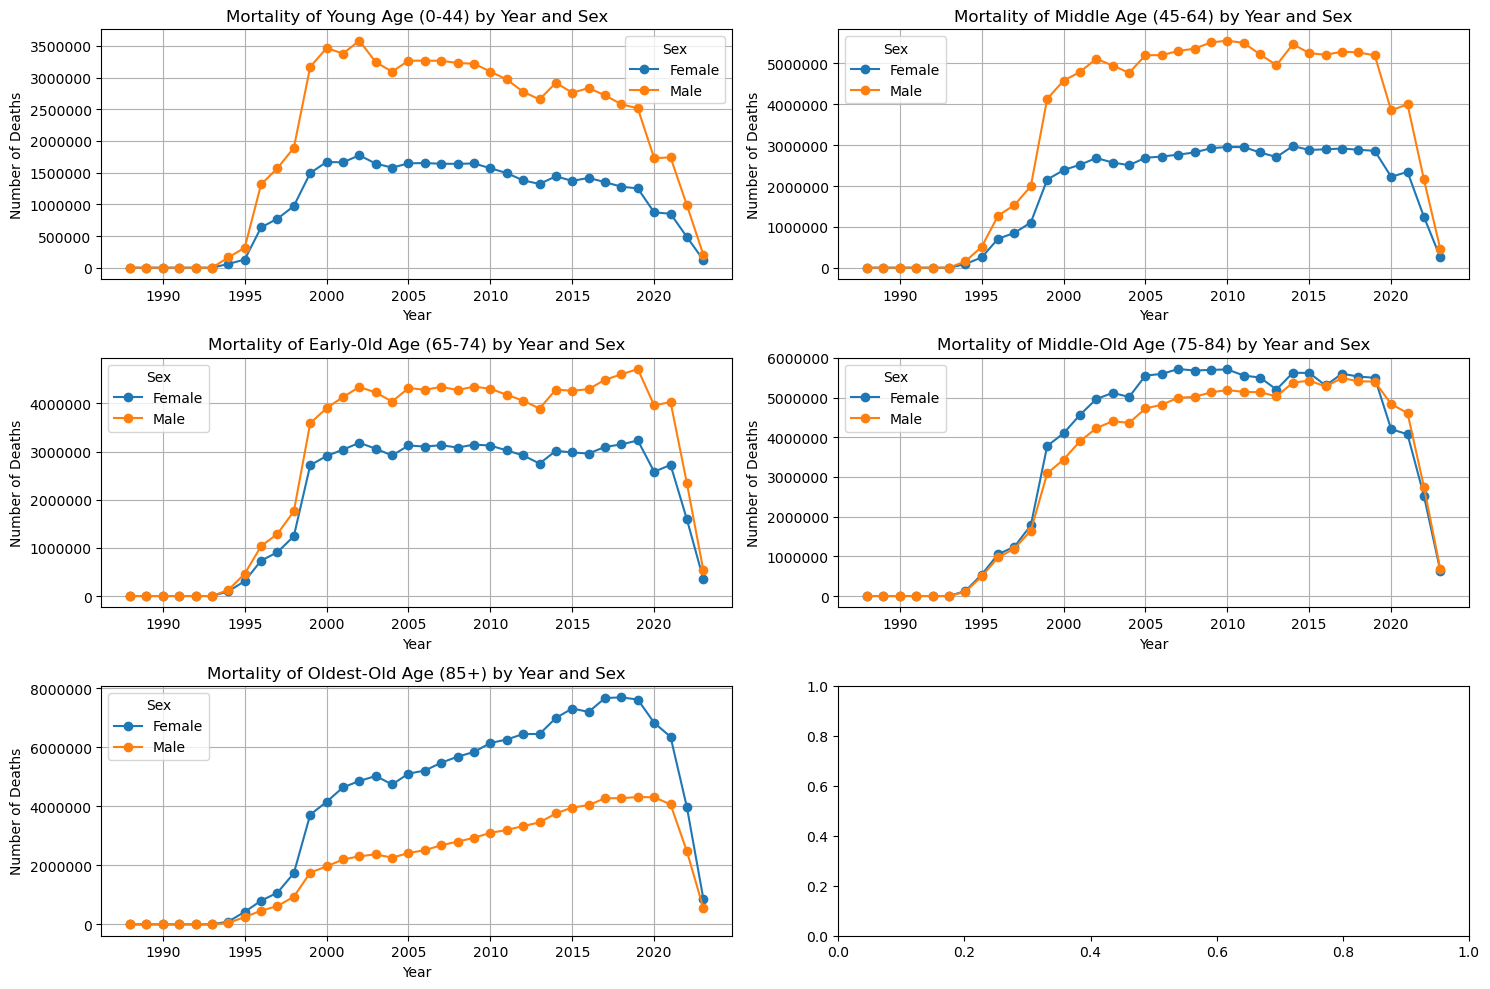

In [29]:
fig, axes= plt.subplots(nrows=3, ncols=2, figsize=(15,10))

young_yearsex.plot(ax= axes[0,0], marker='o')
axes[0,0].set_title('Mortality of Young Age (0-44) by Year and Sex')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Number of Deaths')
axes[0,0].grid(True)
axes[0,0].ticklabel_format(style='plain', axis='y')

middle_yearsex.plot(ax= axes[0,1], marker='o')
axes[0,1].set_title('Mortality of Middle Age (45-64) by Year and Sex')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Number of Deaths')
axes[0,1].grid(True)
axes[0,1].ticklabel_format(style='plain', axis='y')

eo_yearsex.plot(ax= axes[1,0], marker='o')
axes[1,0].set_title('Mortality of Early-0ld Age (65-74) by Year and Sex')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Number of Deaths')
axes[1,0].grid(True)
axes[1,0].ticklabel_format(style='plain', axis='y')

mo_yearsex.plot(ax= axes[1,1], marker='o')
axes[1,1].set_title('Mortality of Middle-Old Age (75-84) by Year and Sex')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Number of Deaths')
axes[1,1].grid(True)
axes[1,1].ticklabel_format(style='plain', axis='y')

oldest_yearsex.plot(ax= axes[2,0], marker='o')
axes[2,0].set_title('Mortality of Oldest-Old Age (85+) by Year and Sex')
axes[2,0].set_xlabel('Year')
axes[2,0].set_ylabel('Number of Deaths')
axes[2,0].grid(True)
axes[2,0].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show();

>- Based on the graph above, we observed that the trend of mortality over the years from 1988-2023 for each age group and their respective gender:
>>- All data from year 1988-1993 are at 0 mortality or lower rates of deaths and increasing from 1994-2000.
>>- The deaths rate pattern seems stable or constant after 2000 until 2018 which all the graphs have sharp decrease of deaths rate for all age group.

>- **(1988-1993)**
>>- Zero or lower rates of deaths. This probably that insufficient data was collected earlier because most of the country didn't start reporting. It doesn't mean that zero deaths occurred, just that no data has been reported within these years.
>- **(1994-1999)**
>>- The deaths rate increases as more countries started to use digitalised recorded and joined the database.
>- **(1999-2018)**
>>- Stable deaths rate as most of the countries maintained reporting the deaths rate. All age group shows stable deaths rate except for Oldest-old age group which the number of deaths inreases within these range year.
>- **(2018-2023)**
>>- Sharp drop of deaths rate for all age group might due to pandemic Covid-19. There's delay in reporting and confirmed by WHO
>>>- "There is a delay of 1–2 years between the end of a calendar year and the availability of death data."
>>- Incomplete and fail in maintaining good reporting and some countries paused and has lower mortality as they delay the submission of the mortality record numbers.

>- I want to visualize the data from 3 different year region which are:
>>- 1989-1999
>>- 1999-2018
>>- 2018-2023

In [126]:
compare_diffyearmortality= grouped_mortality.groupby('Year', as_index=False)[['Young', 'Middle_Age', 'Early_Old', 'Middle_Old', 'Oldest_Old']].sum()
compare_diffyearmortality['Mortality_rate']= compare_diffyearmortality[['Young', 'Middle_Age', 'Early_Old', 'Middle_Old', 'Oldest_Old']].sum(axis=1)
mortality_ratediffcountry= compare_diffyearmortality.drop(columns= ['Young', 'Middle_Age', 'Early_Old', 'Middle_Old', 'Oldest_Old'])

In [127]:
mortality_ratediffcountry

,Year,Mortality_rate
0,1988,1942.0
1,1989,1928.0
2,1990,1856.0
3,1991,1774.0
4,1992,2026.0
5,1993,2086.0
6,1994,1063154.0
7,1995,3684136.0
8,1996,8994592.0
9,1997,11065253.0


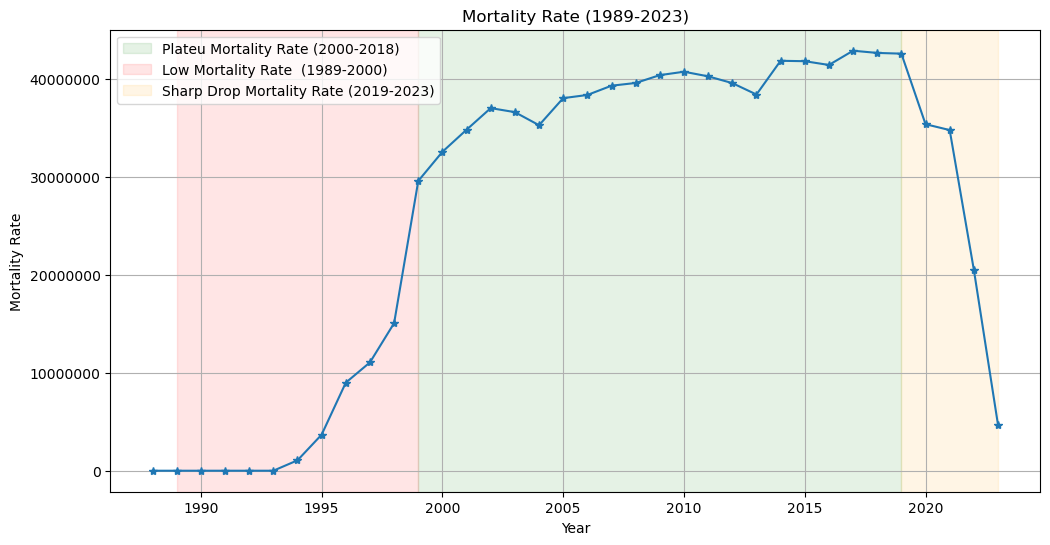

In [133]:
# this plot will differentiate the three divison of year from 1988-2023 based on the mortality rate observed
plt.figure(figsize=(12, 6))
plt.plot(mortality_ratediffcountry['Year'], mortality_ratediffcountry['Mortality_rate'], marker='*')
plt.axvspan(1999, 2019, color='green', alpha=0.1, label='Plateu Mortality Rate (2000-2018)')
plt.axvspan(1989, 1999, color='red', alpha=0.1, label='Low Mortality Rate  (1989-2000)')
plt.axvspan(2019, 2023, color='orange', alpha=0.1, label='Sharp Drop Mortality Rate (2019-2023)')
plt.title('Mortality Rate (1989-2023)')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.grid(True)
plt.show()

>- the plotting above clearly showed that there's significant division year for mortality rate.
>- this plotting is only to compare especially after year 2018 where the data obviously has a sharp drop and this can be assumed that they paused or could not keep up with the mortality record after pandemic Covid-19.
>- the 1999-2018 data still have minor  fluctuation which is still cannot assumed as stable period.
>- However, as the data during 1999-2018, we can say that many countries have joined to record the mortality rate or digitalised record and improvement in healthcare system in data recording.

## Comparison Analytics

#### 1) Is there a significant difference in mortality rates from cardiovascular diseases between early-old (65–74), middle-old (75–84) and oldest old populations?

>- Based on the cause of deaths above, I filter most 15 highest cause of death and find the respective name for each group from the website of International Cause of Disease [ICD](https://icd.who.int/browse10/2019/en#/I20-I25).
>- List 103 and 104 are the general codes for disease that is used when detail information of specific cause of death is unavailable.
>- Note that cause "AAA" and '1000' refers to total deaths from all causes combined. Hence, for clearer analysis, I will only analyse other specific disease that lead to highest number of deaths.

##### Old Group analysis

In [135]:
grouped_mortality.head()

,Country,Year,List,Cause,Sex,Young,Middle_Age,Early_Old,Middle_Old,Oldest_Old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
10,1400,2001,101,1005,Male,0.0,0.0,1.0,0.0,0.0


In [136]:
earlyold_listcause= grouped_mortality.groupby(['List', 'Cause'], as_index= False)['Early_Old'].sum().sort_values(by='Early_Old', ascending=False).head(10)
middleold_listcause= grouped_mortality.groupby(['List', 'Cause'], as_index=False)['Middle_Old'].sum().sort_values(by='Middle_Old', ascending=False).head(10)
oldestold_listcause= grouped_mortality.groupby(['List', 'Cause'], as_index=False)['Oldest_Old'].sum().sort_values(by='Oldest_Old', ascending=False).head(10)

In [137]:
print(earlyold_listcause)
print('\n')
print(middleold_listcause)
print('\n')
print(oldestold_listcause)

     List Cause   Early_Old
2199  104   AAA  62445417.0
0     101  1000  12195985.0
192   103   AAA   8560520.0
64    101  1064   7615352.0
2759  104  C349   4469291.0
67    101  1067   4205555.0
5081  104  I219   4097398.0
69    101  1069   2452510.0
26    101  1026   2387815.0
5545  104  J449   1615356.0


     List Cause  Middle_Old
2199  104   AAA  91808560.0
0     101  1000  14581851.0
64    101  1064  10463901.0
192   103   AAA   9201359.0
67    101  1067   5694867.0
5081  104  I219   5504585.0
2759  104  C349   4091104.0
69    101  1069   3531791.0
5263  104   I64   3161717.0
5092  104  I251   2792656.0


     List Cause  Oldest_Old
2199  104   AAA  95867461.0
0     101  1000   7688827.0
64    101  1064   5418119.0
192   103   AAA   4923001.0
5081  104  I219   4843139.0
5461  104  J189   4158949.0
4036  104   F03   4073396.0
5263  104   I64   3601800.0
8975  104   R54   3599545.0
5092  104  I251   3580045.0


>- **Cardiovascular Diseases**
related to the heart of blood vessels:
>>- 1064: Disease of the circulatory system
>>- 1067: Ischaemic heart diseases
>>- I219: Acute myocardial infarction
>>- I251: Atherosclerotic heart disease
>>- 1069: Cerebrovascular diseases
>>- I64: Stroke 

>- **Respiratory Diseases** 
affect the lungs:
>>- J449: Chronic obstructive pulmonary disease
>>- J189: Pneumonia

>- **Cancer/Neoplasm**
>>- 1026: Neoplasm
>>- C349: Malignant neoplasm of trachea, bronchus and lung


>- **Neurological/Mental Health**
>>- F03: Unspecified dementia

>- **Geriatric**
>>- R54: Senility

>- **J189**
>>- Influenza & Pneumonia

In [34]:
cause_map= {
    '1064': 'Cardiovascular Diseases',
    '1067': 'Cardiovascular Diseases',
    'I219': 'Cardiovascular Diseases',
    'I251': 'Cardiovascular Diseases',
    '1069': 'Cardiovascular Diseases',
    'I64': 'Cardiovascular Diseases',
    'J449': 'Respiratory Diseases',
    'JI89': 'Respiratory Diseases',
    'C349': 'Cancers/Neoplasm',
    '1026': 'Cancers/Neoplasm',
    'F03': 'Neurological/Mental Health',
    'R54': 'Geriatric',
    'J189': 'Influenza and Pneumonia'
}

In [138]:
# remove the all causes of death (AAA, 1000)
earlyold_listcause= earlyold_listcause[~earlyold_listcause['Cause'].isin(['AAA', '1000'])]
middleold_listcause= middleold_listcause[~middleold_listcause['Cause'].isin(['AAA', '1000'])]
oldestold_listcause= oldestold_listcause[~oldestold_listcause['Cause'].isin(['AAA', '1000'])]

# name the cause of death for each group
earlyold_causedeath= earlyold_listcause.copy()
earlyold_causedeath['Death_cause']= earlyold_causedeath['Cause'].map(cause_map)

middleold_causedeath= middleold_listcause.copy()
middleold_causedeath['Death_cause']= middleold_causedeath['Cause'].map(cause_map)

oldestold_causedeath= oldestold_listcause.copy()
oldestold_causedeath['Death_cause']= oldestold_causedeath['Cause'].map(cause_map)

In [139]:
print(earlyold_causedeath)
print('\n')
print(middleold_causedeath)
print('\n')
print(oldestold_causedeath)

     List Cause  Early_Old              Death_cause
64    101  1064  7615352.0  Cardiovascular Diseases
2759  104  C349  4469291.0         Cancers/Neoplasm
67    101  1067  4205555.0  Cardiovascular Diseases
5081  104  I219  4097398.0  Cardiovascular Diseases
69    101  1069  2452510.0  Cardiovascular Diseases
26    101  1026  2387815.0         Cancers/Neoplasm
5545  104  J449  1615356.0     Respiratory Diseases


     List Cause  Middle_Old              Death_cause
64    101  1064  10463901.0  Cardiovascular Diseases
67    101  1067   5694867.0  Cardiovascular Diseases
5081  104  I219   5504585.0  Cardiovascular Diseases
2759  104  C349   4091104.0         Cancers/Neoplasm
69    101  1069   3531791.0  Cardiovascular Diseases
5263  104   I64   3161717.0  Cardiovascular Diseases
5092  104  I251   2792656.0  Cardiovascular Diseases


     List Cause  Oldest_Old                 Death_cause
64    101  1064   5418119.0     Cardiovascular Diseases
5081  104  I219   4843139.0     Cardiovascul

In [140]:
#drop the code cause column in each old group
earlyold_causedeath1= earlyold_causedeath.groupby('Death_cause', as_index=False)['Early_Old'].sum()
middleold_causedeath1= middleold_causedeath.groupby('Death_cause', as_index=False)['Middle_Old'].sum()
oldestold_causedeath1= oldestold_causedeath.groupby('Death_cause', as_index=False)['Oldest_Old'].sum()

print(earlyold_causedeath1)
print('\n')
print(middleold_causedeath1)
print('\n')
print(oldestold_causedeath1)

               Death_cause   Early_Old
0         Cancers/Neoplasm   6857106.0
1  Cardiovascular Diseases  18370815.0
2     Respiratory Diseases   1615356.0


               Death_cause  Middle_Old
0         Cancers/Neoplasm   4091104.0
1  Cardiovascular Diseases  31149517.0


                  Death_cause  Oldest_Old
0     Cardiovascular Diseases  17443103.0
1                   Geriatric   3599545.0
2     Influenza and Pneumonia   4158949.0
3  Neurological/Mental Health   4073396.0


In [141]:
combine_causedeatholdgroup= pd.concat([earlyold_causedeath1, middleold_causedeath1, oldestold_causedeath1], ignore_index=True)
combine_causedeatholdgroup= combine_causedeatholdgroup.groupby('Death_cause', as_index=False).sum(numeric_only=True)
combine_causedeatholdgroup

,Death_cause,Early_Old,Middle_Old,Oldest_Old
0,Cancers/Neoplasm,6857106.0,4091104.0,0.0
1,Cardiovascular Diseases,18370815.0,31149517.0,17443103.0
2,Geriatric,0.0,0.0,3599545.0
3,Influenza and Pneumonia,0.0,0.0,4158949.0
4,Neurological/Mental Health,0.0,0.0,4073396.0
5,Respiratory Diseases,1615356.0,0.0,0.0


In [142]:
old_disease= combine_causedeatholdgroup[combine_causedeatholdgroup['Death_cause']=='Cardiovascular Diseases']

old_disease= old_disease.rename(columns={
    'Early_Old': '65-74',
    'Middle_Old': '75-84',
    'Oldest_Old': '85+'
})

In [143]:
old_disease

,Death_cause,65-74,75-84,85+
1,Cardiovascular Diseases,18370815.0,31149517.0,17443103.0


In [144]:
#melt the old_disease to create a new long format df 
old_disease1= old_disease.melt(id_vars='Death_cause', var_name='Age_Group', value_name='Deaths_number')

#to rename the age group
old_disease1['Age_Group']= old_disease1['Age_Group']

old_disease1

,Death_cause,Age_Group,Deaths_number
0,Cardiovascular Diseases,65-74,18370815.0
1,Cardiovascular Diseases,75-84,31149517.0
2,Cardiovascular Diseases,85+,17443103.0


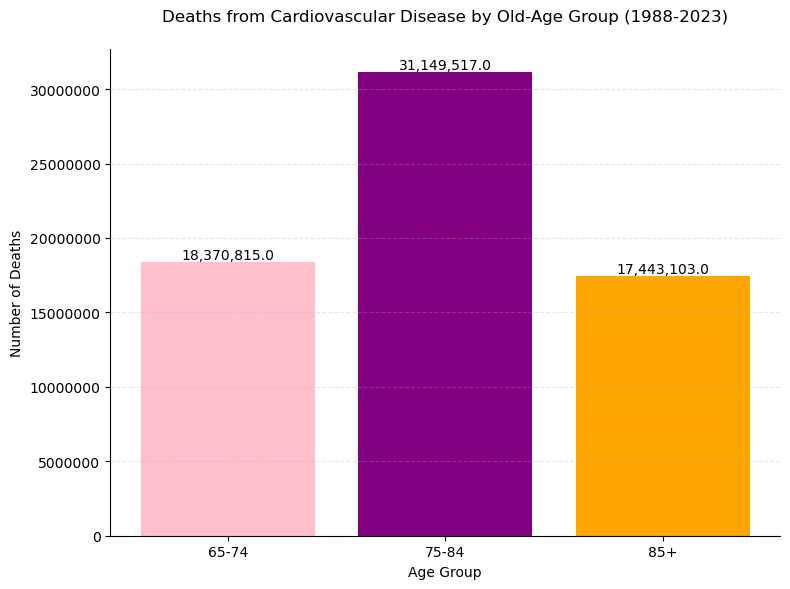

In [145]:
colors = ['pink', 'purple','orange']
fig, ax=plt.subplots(figsize=(8,6))
bars=ax.bar(old_disease1['Age_Group'], old_disease1['Deaths_number'], color=colors)
ax.set_title('Deaths from Cardiovascular Disease by Old-Age Group (1988-2023)', pad=20)
ax.set_xlabel('Age Group')
ax.set_ylabel('Number of Deaths')
ax.ticklabel_format(style='plain', axis='y')

for bar in bars:
    height= bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:,}', ha='center', va='bottom')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

>- There is indeed a significant difference of mortality rates from Cardiovascular Disease by Old-age Group.
>- The middle-old (75-84) age group surprisingly shows the most highest mortality rates.
>- Oldest-old (85+) is surprisingly has lower mortality rate compared to both early-old (65-74) and middle-old (75-84) age group.
>- Atypically, the oldest-old (85+) typically is suspected to have highest mortality as we know, our body system also drained with age. However, this might be probably due to unrecorded death registration in nursing homes or maybe most of them die due to different causes.
>- Also, we cannot being judgemental towards the eldest because some of them are good in maintaining their body health with nutrition and keeping healthy lifestyle compared to young people.
>- We can assume that middle-age is the age where maybe they're hardworking when they're young, forgot to take care of themselves and in the end they suffered when they retired. Not enough money for medicines because they probably priorities other things to survive such as bills and government taxes because some might save money to survive. We can study further if there's other demograhic features such as 'living area', 'job background'.

#### 2) How differ the three most high cause of deaths of oldest-old (85+) age group between United States of America and Russian Federation?
>- These two country are chosen to compare with as the two are the most highest mortality rates in previous analysis.

In [146]:
grouped_mortality.head()

,Country,Year,List,Cause,Sex,Young,Middle_Age,Early_Old,Middle_Old,Oldest_Old
0,1400,2001,101,1000,Male,77.0,92.0,68.0,95.0,0.0
1,1400,2001,101,1000,Female,28.0,34.0,48.0,112.0,0.0
2,1400,2001,101,1001,Male,11.0,5.0,3.0,5.0,0.0
3,1400,2001,101,1001,Female,3.0,5.0,0.0,6.0,0.0
10,1400,2001,101,1005,Male,0.0,0.0,1.0,0.0,0.0


In [147]:
oldestold_causedeath1 #top 3 cause of death

,Death_cause,Oldest_Old
0,Cardiovascular Diseases,17443103.0
1,Geriatric,3599545.0
2,Influenza and Pneumonia,4158949.0
3,Neurological/Mental Health,4073396.0


In [148]:
cause_map

{'1064': 'Cardiovascular Diseases',
 '1067': 'Cardiovascular Diseases',
 'I219': 'Cardiovascular Diseases',
 'I251': 'Cardiovascular Diseases',
 '1069': 'Cardiovascular Diseases',
 'I64': 'Cardiovascular Diseases',
 'J449': 'Respiratory Diseases',
 'JI89': 'Respiratory Diseases',
 'C349': 'Cancers/Neoplasm',
 '1026': 'Cancers/Neoplasm',
 'F03': 'Neurological/Mental Health',
 'R54': 'Geriatric',
 'J189': 'Influenza and Pneumonia'}

In [151]:
#Extract the data we want which we group the stable data with country and cause and sort it the from the highest number of deaths
top_causeoold= grouped_mortality.groupby(['Country','Cause'], as_index=False)['Oldest_Old'].sum().sort_values(by='Oldest_Old', ascending=False)

#extract out the 'all causes' of dead from the dataframe so that we analyse the specific cause of deaths with name
top_causeoold= top_causeoold[~top_causeoold['Cause'].isin(['AAA', '1000'])]

#name the country and the cause of death by merging the dataframe with country codes and mapping with cause of death
top_causeoold1= pd.merge(top_causeoold, code, on='Country', how='left').drop(columns='Country').rename(columns= {'Name':'Country'})
top_causeoold1['Death_cause']= top_causeoold1['Cause'].map(cause_map)
top_causeoold1= top_causeoold1.drop(columns='Cause')
top_causeoold1.head()

,Oldest_Old,Country,Death_cause
0,4037025.0,Russian Federation,Cardiovascular Diseases
1,1967751.0,Russian Federation,Cardiovascular Diseases
2,1852040.0,United States of America,Cardiovascular Diseases
3,1568637.0,Russian Federation,Cardiovascular Diseases
4,1391404.0,Japan,Influenza and Pneumonia


In [152]:
top_causecon= top_causeoold1[(top_causeoold1['Country'].isin(['Russian Federation', 'United States of America'])) & (top_causeoold1['Death_cause'].isin(['Cardiovascular Diseases','Influenza and Pneumonia', 'Neurological/Mental Health']))]
top_causecountry= top_causecon.groupby(['Country', 'Death_cause'], as_index=False)['Oldest_Old'].sum().sort_values(by='Oldest_Old', ascending=False)
top_causecountry

,Country,Death_cause,Oldest_Old
0,Russian Federation,Cardiovascular Diseases,7573413.0
1,United States of America,Cardiovascular Diseases,3553511.0
3,United States of America,Neurological/Mental Health,1337009.0
2,United States of America,Influenza and Pneumonia,523044.0


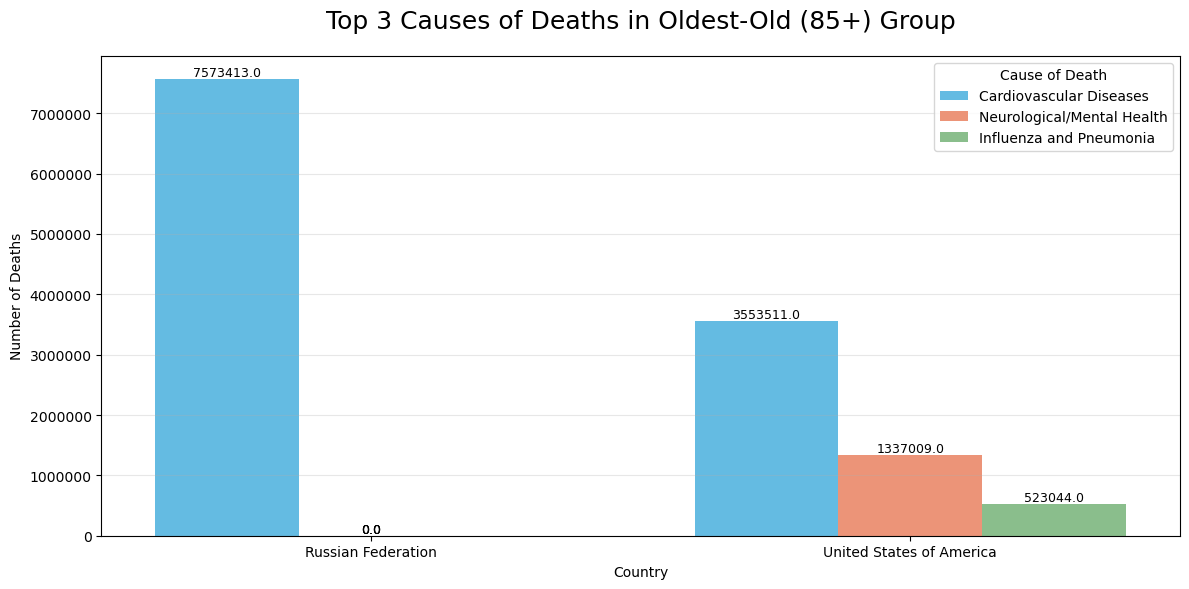

In [153]:
#top_causecountry= top_causecountry.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_causecountry, x='Country', y='Oldest_Old', hue='Death_cause',
            palette=['#4FC3F7', '#FF8A65', '#81C784'])
plt.title('Top 3 Causes of Deaths in Oldest-Old (85+) Group', fontsize=18, pad=20)
plt.xlabel('Country')
plt.ylabel('Number of Deaths')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Cause of Death')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Add labels to graph for clearer vision
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}', (x + width/2, y + height + 50000),
                ha='center', fontsize=9)

plt.show();

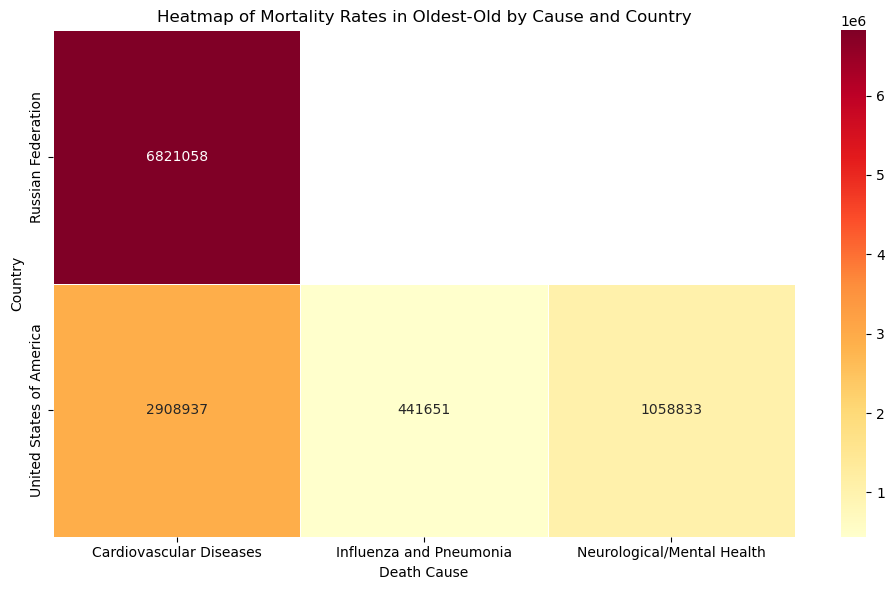

In [49]:
pivot_topcauseold = top_causecountry.pivot(index='Country', columns='Death_cause', values='Oldest_old')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_topcauseold, annot=True, fmt=".0f", cmap="YlOrRd", linewidths=0.5)
plt.title('Heatmap of Mortality Rates in Oldest-Old by Cause and Country')
plt.ylabel('Country')
plt.xlabel('Death Cause')
plt.tight_layout()
plt.show();

In [154]:
pivot_topcauseold

Death_cause,Cardiovascular Diseases,Influenza and Pneumonia,Neurological/Mental Health
Country,,,
Russian Federation,6821058.0,NaN,NaN
United States of America,2908937.0,441651.0,1058833.0


In [158]:
2908937.0 +	441651.0 +	1058833.0

4409421.0

>- Top 2 countries with highest mortality rate:
>>- Russian Federation
>>- United States of America

>- Top 3 causes of deaths:
>>- Cardiovascular Diseases
>>- Neurological/Mental Health
>>- Influenza and Pneumonia


>- Between two top countries that dominates to higher mortality rates from year 1988-2023, Russian Federation is the most highest mortality rate compared to United States of America
>- Eventhough the USA has higher mortality in top 3 causes of deaths, the number still cannot beat the rates of deaths of Russian Federation which only suffers one top cause of deaths.
>- The extreme of mortality rate for Cardiovascular Disease is might be due to huge demograhic area and population size of the country compared to others. Besides, US, Russian Federation is also well known for its upmost technologies, knowledge, sciences, thus means that there's high possibility they too are experience with high work pressure and burden with workload in order to maintain their well socioeconomics.
>- Eventhough, US is a well forward country, they probably have poor healthcare system and fails in maintaining healthy lifestyle as they mostly eat fastfood compared to good nutrition food. 
>- While Russian Federation is only with the cardiovascular disease. The population size also bigger but I can say that healthcare system in this country probably poor than in US as we can see that it only dominates to Cardiovascular disease which is the top cause of deaths.

# Conclusion

In conclusion, as the age increasing, the number of deaths is also increasing. Male has higher number of deaths of the age below 75 age while Female has higher number of deaths above 75 age. The top two countries which have the highest number of deaths from 1988-2023 are Russian Federation and United States of America. The top three cause of deaths are ranked from Cardiovascular Diseases, Neurological/Mental Health and Influenza/Pneumonia. Both countries have higher mortality rate in the deaths cause of Cardiovascular Diseases but Russian Federation's mortality rates is significant to only Cardiovascular Diseases. Eventhough USA has all the top three cause of deaths that contribute to the rate of deaths in the country, Russian Federation is still ranked the highest number of deaths. Last but not least, the most significant age group that contribute the most to top 1 cause of deaths which is Cardiovascular Diseases is the middle-old (75-84) age group. 